In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Grid generation

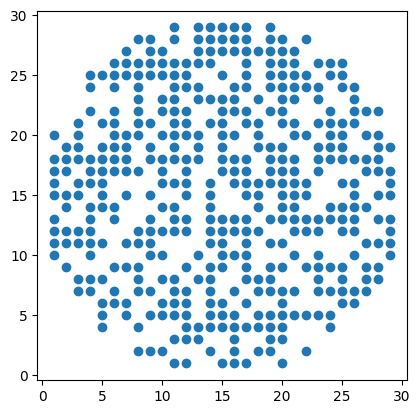

In [2]:
from collab2.foraging.toolkit import _get_grid


def circular_constraint_func(grid, c_x, c_y, R):
    ind = ((grid["x"] - c_x) ** 2 + (grid["y"] - c_y) ** 2) < R**2
    return grid.loc[ind]


grid_size = 30

grid_constraint_params = {
    "c_x": grid_size / 2,
    "c_y": grid_size / 2,
    "R": grid_size / 2,
}
grid = _get_grid(
    grid_size=grid_size,
    sampling_fraction=0.5,
    grid_constraint=circular_constraint_func,
    **grid_constraint_params
)
fig, ax = plt.subplots()
ax.scatter(grid["x"], grid["y"])
ax.set_aspect("equal")

# Local windows

In [3]:
from collab2.foraging.toolkit import (
    _generate_local_windows,
    dataObject,
    rescale_to_grid,
)

num_frames = 8
num_foragers = 3
grid_size = 30
n_nans = int(num_frames * num_foragers / 5)
n_missing = int(num_frames * num_foragers / 5)
gridMin = -1
gridMax = 1

np.random.seed(0)

# generate data
theta = 2 * np.pi * np.random.rand(num_frames * num_foragers)
r = np.random.rand(num_frames * num_foragers)

data = {
    "x": r * np.cos(theta),
    "y": r * np.sin(theta),
    "time": np.tile(np.arange(num_frames), num_foragers),
    "forager": np.concatenate([i * np.ones(num_frames) for i in range(num_foragers)]),
}

foragersDF = pd.DataFrame(data)

# add nan values
nan_ind = np.random.randint(0, num_frames * num_foragers, size=n_nans)
foragersDF.loc[nan_ind, ["x", "y"]] = np.nan

# remove values for certain time points
drop_ind = np.random.randint(0, num_frames * num_foragers, size=n_missing)
foragersDF = foragersDF.drop(drop_ind)

# scaling and subsampling
foragersDF_scaled = rescale_to_grid(
    foragersDF, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
foragers_object = dataObject(foragersDF_scaled, grid_size=grid_size)

display(foragers_object.foragers)

/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:42: UserWarning: 
                NaN values in data. The default behavior of predictor/score generating functions is
                to ignore foragers with missing positional data. To modify, see documentation of
                `derive_predictors_and_scores` and `generate_local_windows`
                
  warnings.warn(
/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:62: UserWarning: 
                    Missing frames encountered for forager 0, adding NaN fillers.
                    The default behavior of predictor/score generating functions is
                    to ignore foragers with missing positional data. To modify, see documentation of
                    `derive_predictors_and_scores` and `generate_local_windows`
                    
  warnings.warn(
/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:62: UserWarning: 
                    Mis

[      x     y  time  forager
 0  13.0  14.0     0      0.0
 1  12.0   5.0     1      0.0
 2  13.0  13.0     2      0.0
 3   NaN   NaN     3      0.0
 4   NaN   NaN     4      0.0
 5  11.0  10.0     5      0.0
 6  11.0  16.0     6      0.0
 7  24.0   7.0     7      0.0,
       x     y  time  forager
 0  21.0  13.0     0      1.0
 1   8.0  20.0     1      1.0
 2   NaN   NaN     2      1.0
 3   NaN   NaN     3      1.0
 4   NaN   NaN     4      1.0
 5  23.0  10.0     5      1.0
 6   NaN   NaN     6      1.0
 7  23.0  20.0     7      1.0,
       x     y  time  forager
 0  20.0  15.0     0      2.0
 1  18.0   9.0     1      2.0
 2  16.0   4.0     2      2.0
 3  15.0  14.0     3      2.0
 4   NaN   NaN     4      2.0
 5   NaN   NaN     5      2.0
 6  11.0  15.0     6      2.0
 7  15.0  13.0     7      2.0]

In [4]:
def plot_local_windows(foragers_object, local_windows, random_state=0):
    ncols = 4
    nrows = np.ceil(foragers_object.num_frames / ncols).astype(int)
    fig, ax = plt.subplots(nrows, ncols, figsize=(10, 5))
    np.random.seed(random_state)
    random_colors = np.random.randint(0, 256, size=(foragers_object.num_foragers, 3))
    # Convert the RGB values to hex format
    colors = ["#{:02x}{:02x}{:02x}".format(r, g, b) for r, g, b in random_colors]

    for t in range(foragers_object.num_frames):
        r = t // ncols
        c = t % ncols
        for f in range(foragers_object.num_foragers):
            if local_windows[f][t] is not None:
                ax[r, c].scatter(
                    local_windows[f][t]["x"],
                    local_windows[f][t]["y"],
                    s=0.3,
                    color=colors[f],
                )
            ax[r, c].scatter(
                foragers_object.foragers[f].loc[t, "x"],
                foragers_object.foragers[f].loc[t, "y"],
                s=10,
                color=colors[f],
            )

        ax[r, c].set_xlim([-1, foragers_object.grid_size])
        ax[r, c].set_ylim([-1, foragers_object.grid_size])
        ax[r, c].set_title(f"t={t}")
        ax[r, c].set_aspect("equal")

    fig.tight_layout(pad=2)

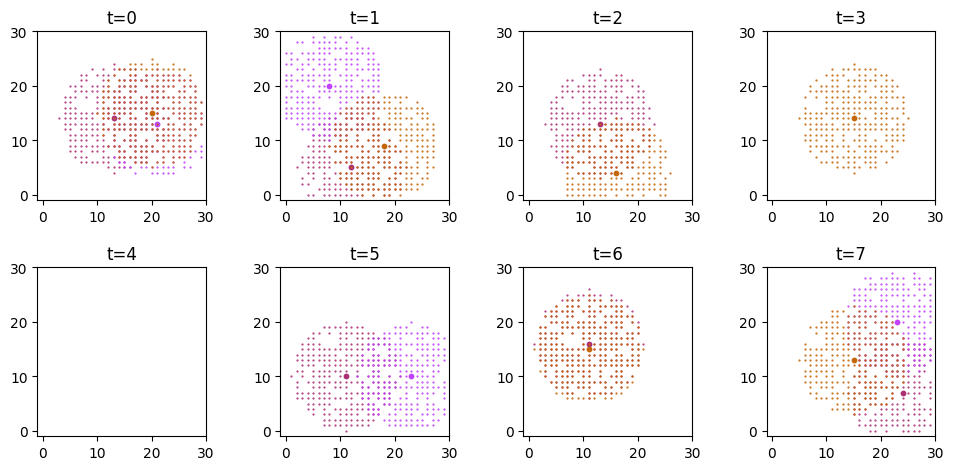

In [5]:
local_windows_params = {
    "foragers": foragers_object.foragers,
    "grid_size": foragers_object.grid_size,
    "window_size": 10,
    "sampling_fraction": 0.75,
    "skip_incomplete_frames": False,
    "grid_constraint": None,
    "grid_constraint_params" : {}
}
local_windows_no_constraint = _generate_local_windows(**local_windows_params)

# check that frames with missing data have no local windows, as required
plot_local_windows(foragers_object, local_windows_no_constraint)

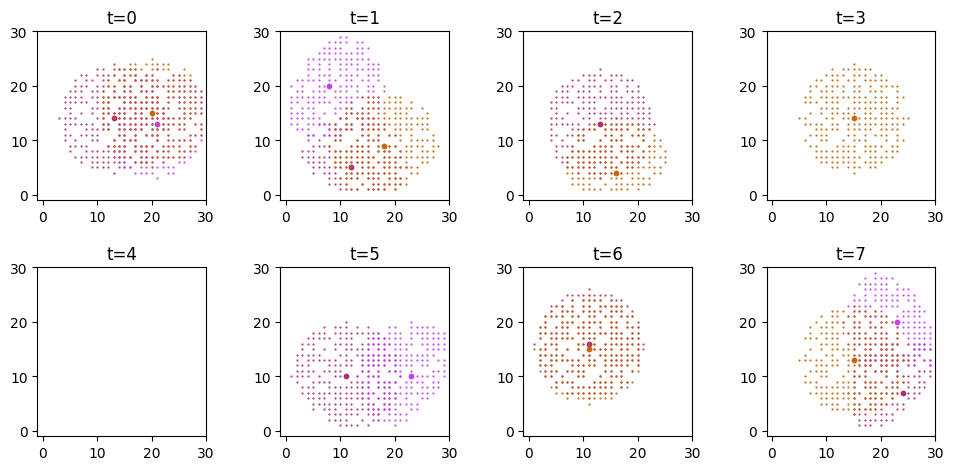

In [6]:
# including a constraint
grid_constraint_params = {    
    "c_x": grid_size / 2,
    "c_y": grid_size / 2,
    "R": grid_size / 2
    }

local_windows_params = {
    "foragers": foragers_object.foragers,
    "grid_size": foragers_object.grid_size,
    "window_size": 10,
    "sampling_fraction": 0.75,
    "skip_incomplete_frames": False,
    "grid_constraint": circular_constraint_func,
    "grid_constraint_params" : grid_constraint_params
}

local_windows_w_constraint = _generate_local_windows(**local_windows_params)
plot_local_windows(foragers_object, local_windows_w_constraint)

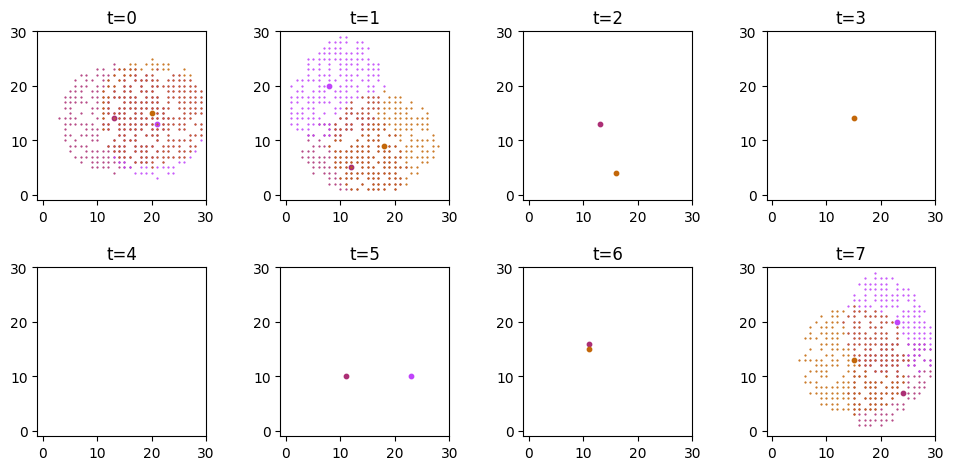

In [7]:
# only keep complete frames
grid_constraint_params = {    
    "c_x": grid_size / 2,
    "c_y": grid_size / 2,
    "R": grid_size / 2
    }

local_windows_params = {
    "foragers": foragers_object.foragers,
    "grid_size": foragers_object.grid_size,
    "window_size": 10,
    "sampling_fraction": 0.75,
    "skip_incomplete_frames": True,
    "grid_constraint": circular_constraint_func,
    "grid_constraint_params" : grid_constraint_params
}
local_windows_w_constraint = _generate_local_windows(**local_windows_params)
plot_local_windows(foragers_object, local_windows_w_constraint)

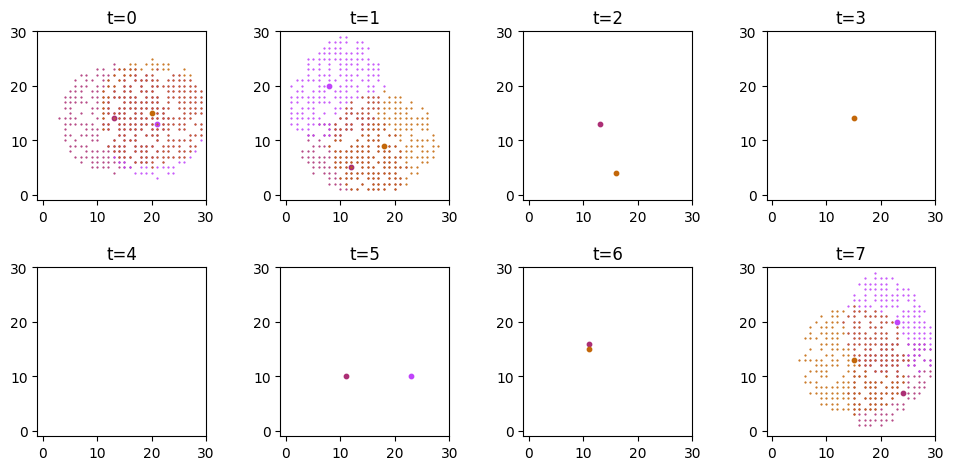

In [8]:
# check non-underscored (exposed) function
from collab2.foraging.toolkit import generate_local_windows

grid_constraint_params = {    
    "c_x": grid_size / 2,
    "c_y": grid_size / 2,
    "R": grid_size / 2
    }

local_windows_kwargs = {
    "window_size": 10,
    "sampling_fraction": 0.75,
    "skip_incomplete_frames": True,
    "grid_constraint": circular_constraint_func,
    "grid_constraint_params" : grid_constraint_params
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows_w_constraint_2 = generate_local_windows(foragers_object)

plot_local_windows(foragers_object, local_windows_w_constraint_2)